# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- Использовать CrossEntropyLoss и L2-регуляризацию.
- Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- (**+2 балла**) Добавить Batch normalization.
- (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- (**+1 балл**) Также реализовать оптимизатор Adam.

## Dataset
The **SVHN (Street View House Numbers)** dataset is a large-scale image dataset consisting of color images of house numbers (digits 0-9) obtained from Google Street View images. It is often used for benchmarking machine learning models, particularly in the field of digit recognition.

### Key Details:
- **Content**: The dataset contains real-world images of house numbers taken from Street View. The numbers are captured in varying conditions, such as different orientations, sizes, and lighting conditions.
- **Size**:
  - **Training Set**: 73,257 labeled images.
  - **Test Set**: 26,032 labeled images.
  - **Image Dimensions**: The images are 32x32 pixels in size.
- **Labels**: Each image contains a single digit (0-9) representing a house number.
- **Challenges**: The dataset poses challenges due to the variability of the digits' positions, scales, and backgrounds in the images, making it a useful dataset for testing and improving models' robustness in real-world scenarios.


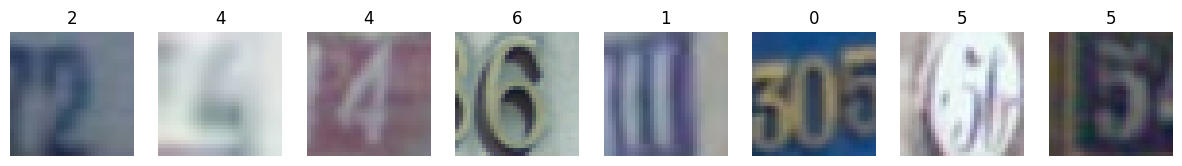

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from itertools import product
import torch.nn as nn
import torchmetrics
from tqdm import tqdm
import torch.optim as optim

# Define transformations to convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the SVHN dataset
trainset = torchvision.datasets.SVHN(root='./svhn-dataset', split='train', download=True, transform=transform)
testset = torchvision.datasets.SVHN(root='./svhn-dataset', split='test', download=True, transform=transform)

# Split the training data into training and validation sets
val_size = 7000
train_size = len(trainset) - val_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Function to display a grid of images
def display_images(images, labels):
    # Denormalize the images for display
    images = images / 2 + 0.5
    np_images = images.numpy()
    
    # Plot the images
    fig, axes = plt.subplots(1, 8, figsize=(15, 2))
    for i in range(8):
        axes[i].imshow(np.transpose(np_images[i], (1, 2, 0)))
        axes[i].set_title(str(labels[i].item()))  # Display the label as title
        axes[i].axis('off')
    plt.show()

# Get a batch of images and labels from the train loader
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display the first few images with their labels
display_images(images[:8], labels[:8])

## Implementation of layers and neural network

In [6]:
# Define the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fully connected layer with custom trainable parameters
class CustomLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(out_dim, in_dim) * 0.01)
        self.b = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):
        return torch.matmul(x, self.W.t()) + self.b

# Simple implementation of the ReLU activation
class CustomReLU(nn.Module):
    def forward(self, x):
        return torch.relu(x)

# Model without Batch Normalization
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.connected1 = CustomLinear(3 * 32 * 32, 128)
        self.relu = CustomReLU()
        self.connected2 = CustomLinear(128, 64)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the image into a vector
        x = self.connected1(x)
        x = self.relu(x)
        x = self.connected2(x)
        return x

# Model with Batch Normalization
class NetworkWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.connected1 = CustomLinear(3 * 32 * 32, 128)
        self.batch = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.connected2 = CustomLinear(128, 64)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = self.connected1(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.connected2(x)
        return x

## Implementation of Adam optimization

In [7]:
# Custom Adam optimizer implementation
class CustomAdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            grad = p.grad.data
            if self.weight_decay:
                grad = grad + self.weight_decay * p.data
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p.data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.data.zero_()

## Hyperparameter selection

Training SimpleNetwork with optimizer adam at lr=0.001


Epoch 1/10 - Train Loss: 1.3752, Val Loss: 0.9659
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.8609, Val Loss: 0.8044
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.7382, Val Loss: 0.7612
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.6813, Val Loss: 0.7256
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.6383, Val Loss: 0.7591
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.6070, Val Loss: 0.6919
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.5839, Val Loss: 0.6578
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.5631, Val Loss: 0.6660
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.5467, Val Loss: 0.6729
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.5326, Val Loss: 0.6347
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


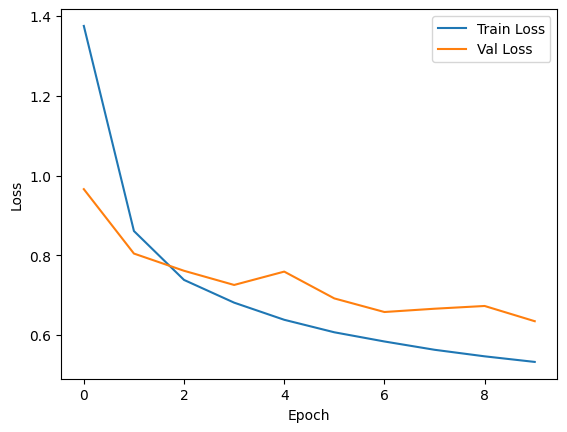

Training SimpleNetwork with optimizer rmsprop at lr=0.001


Epoch 1/10 - Train Loss: 0.5977, Val Loss: 0.6702
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.5398, Val Loss: 0.8751
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.5297, Val Loss: 1.3472
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.5210, Val Loss: 0.7635
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.5087, Val Loss: 0.6450
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.5038, Val Loss: 0.6824
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.4959, Val Loss: 0.8912
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.4877, Val Loss: 0.7206
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.4803, Val Loss: 0.7418
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.4764, Val Loss: 0.8101
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


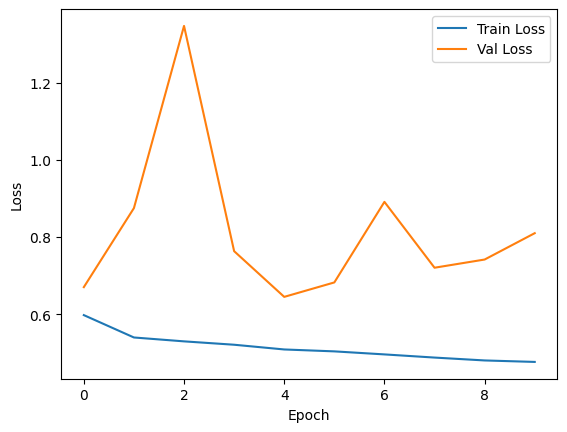

Training SimpleNetwork with optimizer momentum at lr=0.001


Epoch 1/10 - Train Loss: 0.3844, Val Loss: 0.5799
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.3551, Val Loss: 0.5818
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.3460, Val Loss: 0.5906
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.3422, Val Loss: 0.5877
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.3383, Val Loss: 0.5955
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.3361, Val Loss: 0.5970
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.3336, Val Loss: 0.6022
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.3325, Val Loss: 0.6013
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.3319, Val Loss: 0.5921
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.3302, Val Loss: 0.6030
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


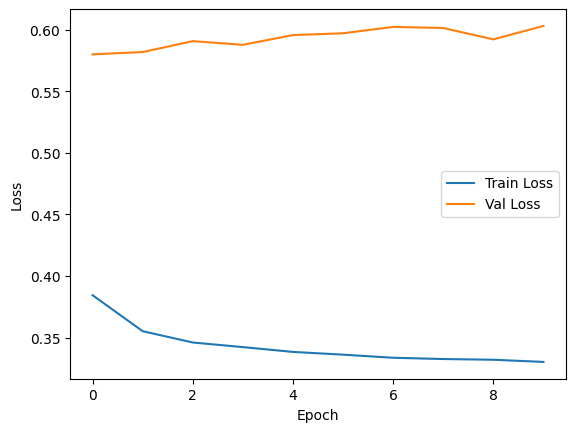

Training SimpleNetwork with optimizer adam at lr=0.01


Epoch 1/10 - Train Loss: 1.7019, Val Loss: 1.3333
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 1.6238, Val Loss: 2.3921
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 1.5846, Val Loss: 1.5429
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 1.5964, Val Loss: 1.6598
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 1.5769, Val Loss: 1.5339
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 1.5386, Val Loss: 1.5737
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 1.5616, Val Loss: 1.3703
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 1.5002, Val Loss: 1.7785
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 1.4817, Val Loss: 1.7107
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 1.4664, Val Loss: 1.4771
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


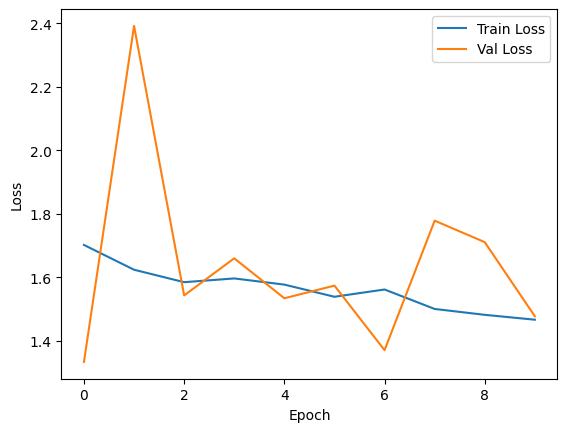

Training SimpleNetwork with optimizer rmsprop at lr=0.01


Epoch 1/10 - Train Loss: 3.5024, Val Loss: 1.3337
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 1.8852, Val Loss: 1.9826
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 1.8959, Val Loss: 3.1682
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 1.8199, Val Loss: 4.3577
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 1.7874, Val Loss: 1.7464
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 1.7372, Val Loss: 2.2898
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 1.7004, Val Loss: 2.8901
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 1.6547, Val Loss: 1.4828
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 1.6481, Val Loss: 4.9694
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 1.6497, Val Loss: 2.7696
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


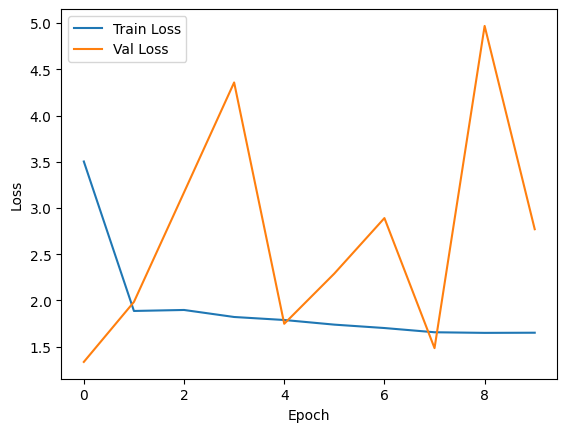

Training SimpleNetwork with optimizer momentum at lr=0.01


Epoch 1/10 - Train Loss: 1.7935, Val Loss: 2.1089
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 1.5081, Val Loss: 1.9064
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 1.3854, Val Loss: 1.9177
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 1.3139, Val Loss: 1.8916
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 1.3108, Val Loss: 1.8740
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 1.2837, Val Loss: 1.8031
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 1.2460, Val Loss: 1.7531
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 1.2368, Val Loss: 1.6566
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 1.1763, Val Loss: 1.8331
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 1.1846, Val Loss: 1.6473
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


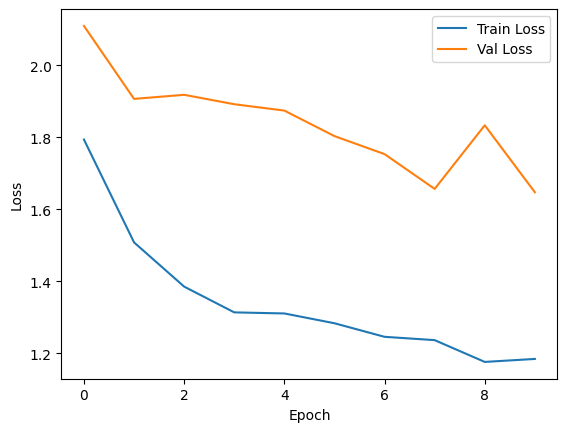

Training NetworkWithBN with optimizer adam at lr=0.001


Epoch 1/10 - Train Loss: 1.4824, Val Loss: 1.0589
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.9530, Val Loss: 0.8974
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.8114, Val Loss: 0.7424
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.7372, Val Loss: 0.7418
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.6973, Val Loss: 0.6799
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.6607, Val Loss: 0.7047
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.6363, Val Loss: 0.6590
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.6167, Val Loss: 0.6250
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.5924, Val Loss: 0.6134
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.5846, Val Loss: 0.5935
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


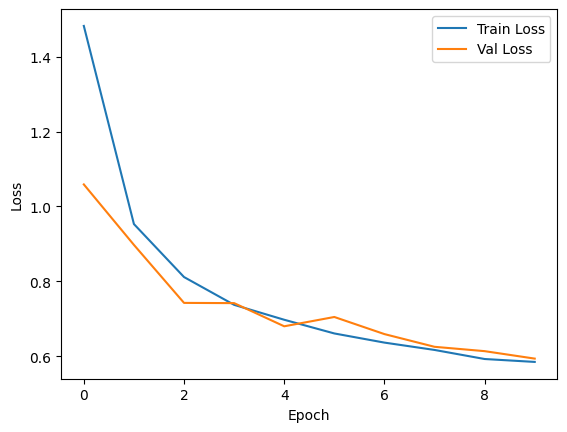

Training NetworkWithBN with optimizer rmsprop at lr=0.001


Epoch 1/10 - Train Loss: 0.6175, Val Loss: 0.9209
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.5734, Val Loss: 0.8162
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.5636, Val Loss: 0.6581
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.5514, Val Loss: 0.6102
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.5456, Val Loss: 0.8703
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.5334, Val Loss: 0.6249
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.5230, Val Loss: 0.8522
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.5188, Val Loss: 0.6090
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.5076, Val Loss: 0.7487
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.5065, Val Loss: 0.6241
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


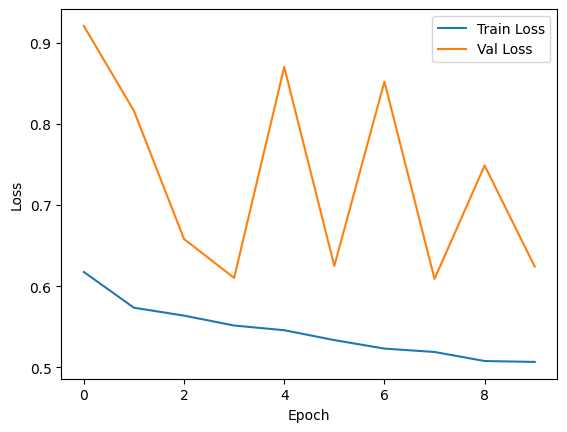

Training NetworkWithBN with optimizer momentum at lr=0.001


Epoch 1/10 - Train Loss: 0.4389, Val Loss: 0.5348
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.4231, Val Loss: 0.5230
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.4139, Val Loss: 0.5214
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.4108, Val Loss: 0.5236
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.4105, Val Loss: 0.5187
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.4072, Val Loss: 0.5197
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.4047, Val Loss: 0.5170
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.4042, Val Loss: 0.5193
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.4013, Val Loss: 0.5163
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.4019, Val Loss: 0.5206
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


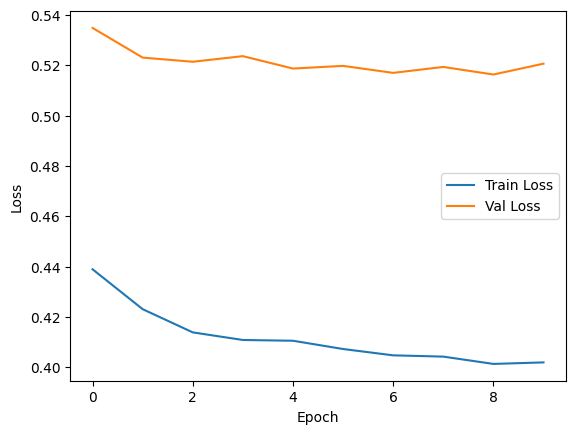

Training NetworkWithBN with optimizer adam at lr=0.01


Epoch 1/10 - Train Loss: 1.0258, Val Loss: 0.8858
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.8415, Val Loss: 0.8102
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.7781, Val Loss: 0.7704
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.7354, Val Loss: 0.7917
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.7093, Val Loss: 0.7262
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.6886, Val Loss: 0.7369
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.6701, Val Loss: 0.6623
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.6522, Val Loss: 0.6631
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.6359, Val Loss: 0.6853
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.6306, Val Loss: 0.6799
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


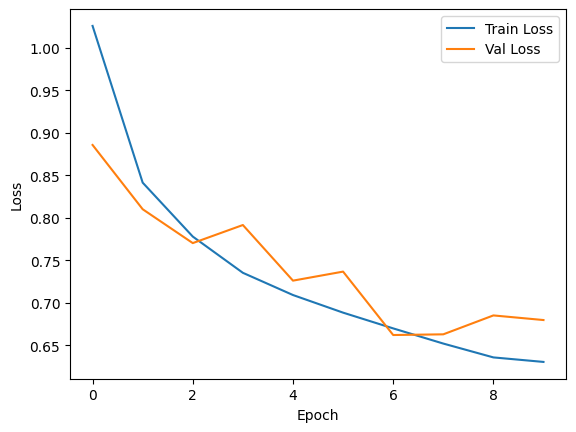

Training NetworkWithBN with optimizer rmsprop at lr=0.01


Epoch 1/10 - Train Loss: 0.6832, Val Loss: 0.6949
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.6269, Val Loss: 0.7282
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.6109, Val Loss: 0.6382
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.6011, Val Loss: 0.7287
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.5925, Val Loss: 0.7970
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.5837, Val Loss: 0.7331
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.5765, Val Loss: 0.6795
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.5709, Val Loss: 1.0491
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.5613, Val Loss: 1.0215
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.5590, Val Loss: 0.6055
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


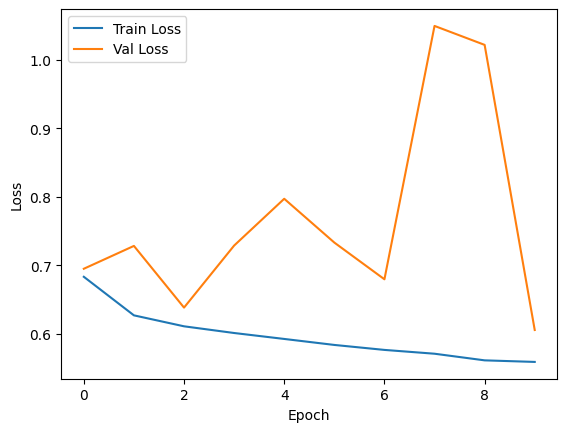

Training NetworkWithBN with optimizer momentum at lr=0.01


Epoch 1/10 - Train Loss: 0.4784, Val Loss: 0.5546
Gradient check at epoch 1:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 2/10 - Train Loss: 0.4571, Val Loss: 0.5481
Gradient check at epoch 2:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 3/10 - Train Loss: 0.4510, Val Loss: 0.5489
Gradient check at epoch 3:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 4/10 - Train Loss: 0.4519, Val Loss: 0.5409
Gradient check at epoch 4:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 5/10 - Train Loss: 0.4426, Val Loss: 0.5448
Gradient check at epoch 5:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 6/10 - Train Loss: 0.4421, Val Loss: 0.5397
Gradient check at epoch 6:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 7/10 - Train Loss: 0.4434, Val Loss: 0.5404
Gradient check at epoch 7:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 8/10 - Train Loss: 0.4387, Val Loss: 0.5410
Gradient check at epoch 8:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 9/10 - Train Loss: 0.4390, Val Loss: 0.5427
Gradient check at epoch 9:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


Epoch 10/10 - Train Loss: 0.4354, Val Loss: 0.5342
Gradient check at epoch 10:
Gradient check passed for connected1.W.
Gradient check passed for connected1.b.
Gradient check passed for batch.weight.
Gradient check passed for batch.bias.
Gradient check passed for connected2.W.
Gradient check passed for connected2.b.


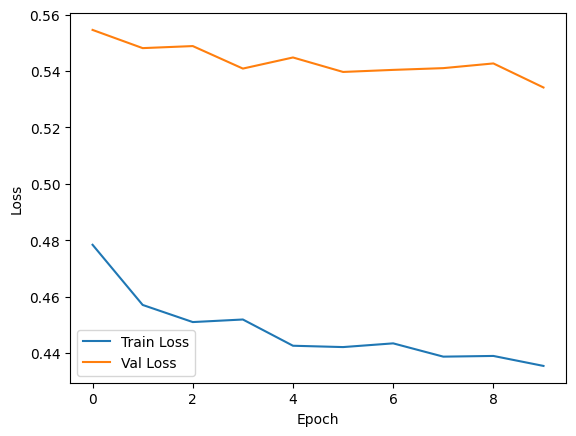

In [8]:
def gradient_check(model, criterion, inputs, labels, epsilon=1e-5, tolerance=1e-4):
    model.eval()
    model.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            analytic_grad = param.grad.clone().detach()
            numerical_grad = torch.zeros_like(param)
            num_checks = min(5, param.numel())
            param_data_flat = param.data.view(-1)
            numerical_grad_flat = numerical_grad.view(-1)
            analytic_grad_flat = analytic_grad.view(-1)
            
            for i in range(num_checks):
                original = param_data_flat[i].item()
                param_data_flat[i] = original + epsilon
                loss_plus = criterion(model(inputs), labels)
                param_data_flat[i] = original - epsilon
                loss_minus = criterion(model(inputs), labels)
                param_data_flat[i] = original

                numerical_grad_flat[i] = (loss_plus - loss_minus) / (2 * epsilon)
            
            diff = torch.norm(analytic_grad_flat[:num_checks] - numerical_grad_flat[:num_checks]) / \
                   (torch.norm(analytic_grad_flat[:num_checks]) + torch.norm(numerical_grad_flat[:num_checks]) + 1e-7)
            if diff.item() > tolerance:
                print(f"WARNING: Gradient check failed for {name}!")
            else:
                print(f"Gradient check passed for {name}.")
    
    model.train()

def run_training(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            optimizer.zero_grad()
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss_val = loss_fn(predictions, batch_y)
            loss_val.backward()
            optimizer.step()
            epoch_loss += loss_val.item()
        avg_train = epoch_loss / len(train_loader)
        train_losses.append(avg_train)

        # Validation phase
        model.eval()
        total_val = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                preds = model(batch_x)
                total_val += loss_fn(preds, batch_y).item()
        avg_val = total_val / len(val_loader)
        val_losses.append(avg_val)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

        # Perform gradient check on a small batch
        sample_x, sample_y = next(iter(train_loader))
        sample_x, sample_y = sample_x[:5].to(device), sample_y[:5].to(device)
        print(f"Gradient check at epoch {epoch+1}:")
        gradient_check(model, loss_fn, sample_x, sample_y)

    return train_losses, val_losses

# Define models, learning rates, and optimizers to test
model_choices = [SimpleNetwork(), NetworkWithBN()]
lr_values = [0.001, 0.01]
optimizers_dict = {
    'adam': lambda params, lr: CustomAdamOptimizer(params, lr=lr),
    'rmsprop': optim.RMSprop,
    'momentum': lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9)
}

results = []

for net_model, lr_val, opt_name in product(model_choices, lr_values, optimizers_dict.keys()):
    net = net_model.to(device)
    criterion = nn.CrossEntropyLoss()
    opt = optimizers_dict[opt_name](net.parameters(), lr=lr_val)
    print(f"Training {net.__class__.__name__} with optimizer {opt_name} at lr={lr_val}")
    tr_losses, vl_losses = run_training(net, trainloader, valloader, criterion, opt, num_epochs=10)

    # Plot the train/validation loss curves
    plt.figure()
    plt.plot(tr_losses, label='Train Loss')
    plt.plot(vl_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    results.append((net, tr_losses, vl_losses, opt_name, lr_val))

In [9]:
best_result = min(results, key=lambda res: res[2][-1])

print(f'Best combination of params is: Model - {best_result[0]}, '
      f'optimizer - {best_result[3]}, lr - {best_result[4]}')
print(f'Best validation loss after 10 epochs - {best_result[2][-1]}')

Best combination of params is: Model - NetworkWithBN(
  (connected1): CustomLinear()
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (connected2): CustomLinear()
), optimizer - momentum, lr - 0.001
Best validation loss after 10 epochs - 0.5206055479970846


In [10]:
best_model = best_result[0] 
best_optimizer_name = best_result[3]
best_lr = best_result[4]

best_model = best_model.to(device)
criterion = nn.CrossEntropyLoss()
best_optimizer = optimizers_dict[best_optimizer_name](best_model.parameters(), lr=best_lr)

# Define evaluation function
def evaluate_model(model, testloader, device):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10).to(device)
    
    # Run evaluation without gradient calculation
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            accuracy_metric.update(predictions, labels)

    print(f"Accuracy of the model on test images: {accuracy_metric.compute() * 100:.10f}%")
    accuracy_metric.reset()  # Reset the metric for future evaluations

# Call evaluation on the best model
evaluate_model(best_model, testloader, device)

Accuracy of the model on test images: 83.5394897461%


## Best Combination of Parameters

The best combination of parameters is: 

**Model:**  
`NetworkWithBN(
  (layer1): CustomLinear()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (layer2): CustomLinear()
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (layer3): CustomLinear()
)`

**Optimizer:** `momentum`  
**Learning Rate:** `0.001`